<a href="https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/3_BetterOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import libraries**

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

cuda


## **1. Prepare dataset**


In [ ]:
train_dataset = FashionMNIST(root="./data",
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.13MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 512
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network with `Better Optimizer `**




In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.05)
        nn.init.constant_(m.bias, val=0.0)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    x = self.layer3(x)
    x = nn.Sigmoid()(x)
    x = self.layer4(x)
    x = nn.Sigmoid()(x)
    x = self.layer5(x)
    x = nn.Sigmoid()(x)
    x = self.layer6(x)
    x = nn.Sigmoid()(x)
    x = self.layer7(x)
    x = nn.Sigmoid()(x)
    output = self.output(x)
    return output

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10

model = MLP(input_dims, hidden_dims, output_dims).to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)

## **3. Training**

In [ ]:
epochs = 100
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
  # train
  train_loss = 0.0
  train_acc = 0.0
  num_sample = 0

  model.train()
  for X_train, y_train in train_loader:
    X_train, y_train = X_train.to(device), y_train.to(device)

    #reset
    optimizer.zero_grad()

    #output
    output = model(X_train)

    loss = criterion(output, y_train)

    # gradient
    loss.backward()
    # update weight, bias
    optimizer.step()

    # cumulative
    train_loss += loss.item()
    train_acc += (torch.argmax(output, dim=1) == y_train).sum().item()
    num_sample += len(y_train)
  train_loss /= len(train_loader)
  train_acc /= num_sample
  train_acc_list.append(train_acc)
  train_loss_list.append(train_loss)

  # validation
  val_loss = 0.0
  val_acc = 0.0
  num_sample = 0

  model.eval()
  with torch.no_grad():
    for X_val, y_val in val_loader:
      X_val, y_val = X_val.to(device), y_val.to(device)

      output = model(X_val)

      loss = criterion(output, y_val)

      #cumulative
      val_loss += loss.item()
      val_acc += (torch.argmax(output, 1) == y_val).sum().item()
      num_sample += len(y_val)

  val_loss /= len(val_loader)
  val_acc /= num_sample
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)

  print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f},Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f} , Val_Acc:{val_acc:.4f}")

EPOCH 1/100, Train_Loss: 1.7031,Train_Acc: 0.1976, Validation Loss: 1.7011 , Val_Acc:0.1928
EPOCH 2/100, Train_Loss: 1.6874,Train_Acc: 0.1980, Validation Loss: 1.6955 , Val_Acc:0.1925
EPOCH 3/100, Train_Loss: 1.6800,Train_Acc: 0.1970, Validation Loss: 1.6982 , Val_Acc:0.1927
EPOCH 4/100, Train_Loss: 1.6682,Train_Acc: 0.2104, Validation Loss: 1.6094 , Val_Acc:0.2887
EPOCH 5/100, Train_Loss: 1.4834,Train_Acc: 0.3097, Validation Loss: 1.4348 , Val_Acc:0.3373
EPOCH 6/100, Train_Loss: 1.1622,Train_Acc: 0.5061, Validation Loss: 0.9934 , Val_Acc:0.5607
EPOCH 7/100, Train_Loss: 0.9129,Train_Acc: 0.6259, Validation Loss: 0.8412 , Val_Acc:0.7017
EPOCH 8/100, Train_Loss: 0.7809,Train_Acc: 0.7164, Validation Loss: 0.7519 , Val_Acc:0.7312
EPOCH 9/100, Train_Loss: 0.6982,Train_Acc: 0.7533, Validation Loss: 0.6713 , Val_Acc:0.7713
EPOCH 10/100, Train_Loss: 0.6438,Train_Acc: 0.7770, Validation Loss: 0.6345 , Val_Acc:0.7858
EPOCH 11/100, Train_Loss: 0.6152,Train_Acc: 0.7846, Validation Loss: 0.6188 , V

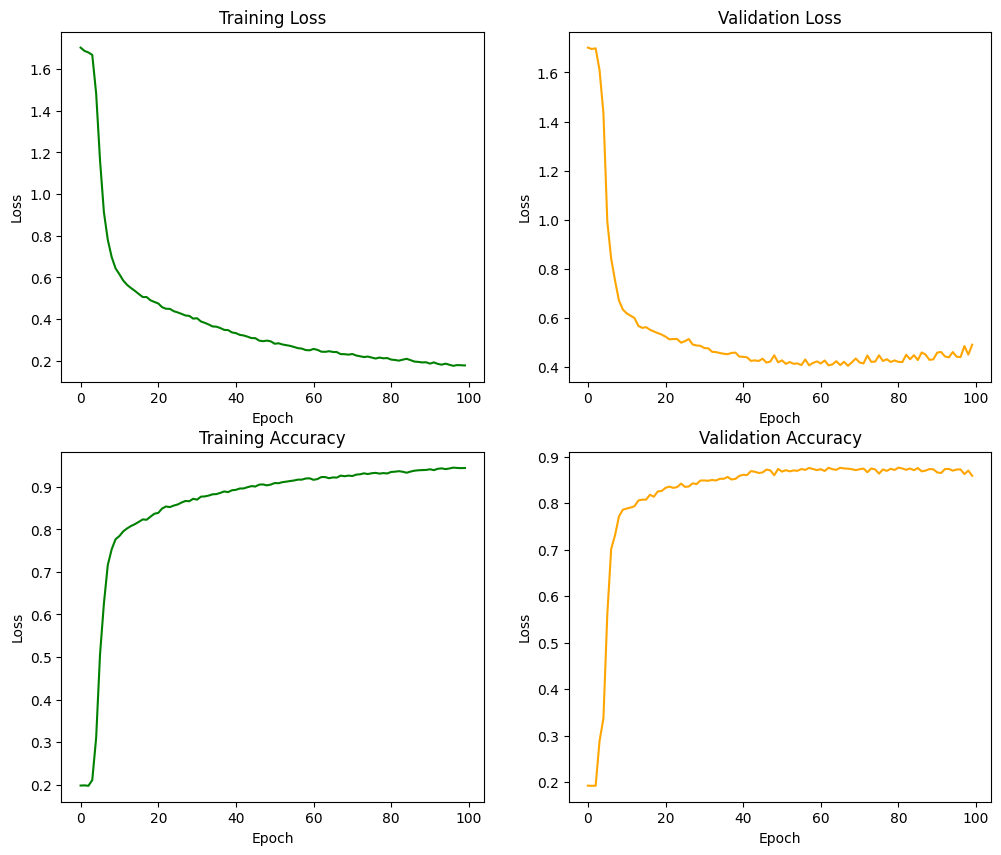

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
ax[0,0].plot(train_loss_list, color='green')
ax[0,0].set(title='Training Loss', xlabel='Epoch', ylabel='Loss')

ax[0,1].plot(val_loss_list, color='orange')
ax[0,1].set(title='Validation Loss', xlabel='Epoch', ylabel='Loss')

ax[1,0].plot(train_acc_list, color='green')
ax[1,0].set(title='Training Accuracy', xlabel='Epoch', ylabel='Accuracy')

ax[1,1].plot(val_acc_list, color='orange')
ax[1,1].set(title='Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')

plt.show()

## **4. Evaluation**

In [ ]:
test_label = []
test_predict = []

model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    output = model(X_test)

    # transfer to CP, currently it is tensor
    test_label.append(y_test.cpu())
    test_predict.append(output.cpu())

  test_label = torch.cat(test_label, dim=0)
  test_predict = torch.cat(test_predict, dim=0)
  test_acc = (torch.argmax(test_predict, dim=1) == test_label).sum().item()/len(test_label)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.8532


In [ ]:
val_label = []
val_predict = []

model.eval()
with torch.no_grad():
  for X_val, y_val in val_loader:
    X_val, y_val = X_val.to(device), y_val.to(device)

    output = model(X_val)

    # transfer to CP, currently it is tensor
    val_label.append(y_val.cpu())
    val_predict.append(output.cpu())

  val_label = torch.cat(val_label, dim=0)
  val_predict = torch.cat(val_predict, dim=0)
  val_acc = (torch.argmax(val_predict, dim=1) == val_label).sum().item()/len(val_label)

print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.8588
